# Time Series

## 1 - Data Prep

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
%matplotlib inline

from datetime import datetime
root = "../"

In [2]:
population = pd.read_csv(root + 'CSV/Population/population_08_18.csv', index_col=[0])
for col in population:
    if col != "MUNCOD":
        year = "20" + col.split("_")[1]
        population = population.rename(columns={col: year})
population = population.astype(int)
population.head()

,2018,MUNCOD,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
0,23167,110001,25437,25506,25578,25652,25728,24069,24228,24422,24354,24577
1,106168,110002,107345,105896,104401,102860,101269,92747,91570,90354,85541,84581
2,5438,110003,6224,6289,6355,6424,6495,6132,6221,6309,6695,6777
3,84813,110004,88507,87877,87226,86556,85863,79330,78959,78601,78675,78263
4,16444,110005,17934,17959,17986,18013,18041,16852,16939,17030,16622,16784


In [31]:
suicide_path = root + 'CSV/TabNet/Suicides/'
years = [str(x) for x in range(2008,2019)]
country_rate_list = []
for year in years:
    suicide_total_df = pd.read_csv(suicide_path + "suicide_" + year + ".csv", sep=";")
    suicide_total_df = suicide_total_df[suicide_total_df["Município"] == "Total"]
    total_of_suicides = suicide_total_df["Total"].values[0]
    total_population = population[year].sum()
    country_rate = total_of_suicides/total_population * 100000
    country_rate_list.append(country_rate)
brazil_suicide_df = pd.DataFrame({"YEAR" : years, "RATE": country_rate_list})
brazil_suicide_df.head()

,YEAR,RATE
0,2008,4.919499
1,2009,4.894867
2,2010,4.953529
3,2011,5.121133
4,2012,5.321923


In [3]:
path = root + 'CSV/TabNet/Internacoes/'
suicide_path = root + 'CSV/TabNet/Suicides/'
df_final = pd.DataFrame()
list_of_diseases = ['TRANSTORNOS_DE_HUMOR_[AFETIVOS]',
 'TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁLCOOL',
 'NEOPLASIA_MALIGNA_DO_CÓLON',
 'NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES',
 'TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT',
 'BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC',
 'NEOPL_MALIG_JUNÇÃO_RETOSSIGM_RETO_ÂNUS_CANAL_ANAL',
 'OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE',
 'TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS',
 'FLEBITE_TROMBOFLEBITE_EMBOLIA_E_TROMBOSE_VENOSA',
 'OUTRAS_DOENÇAS_ISQUÊMICAS_DO_CORAÇÃO',
 'TRANSTORNOS_DOS_NERVOS_RAÍZES_E_PLEXOS_NERVOSOS',
 'NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC',
 'DOENÇAS_DO_APÊNDICE',
 'COLELITÍASE_E_COLECISTITE',
 'NEOPLASIA_MALIGNA_DO_ESÔFAGO',
 'OUTROS_TRANSTRONOS_ARTICULARES',
 'UROLITÍASE',
 'PANCREATITE_AGUDA_E_OUTRAS_DOENÇAS_DO_PÂNCREAS',
 'TRANSTORNOS_DA_DENSIDADE_E_DA_ESTRUTURA_ÓSSEAS']
month_dic = {
    "Jan": "January",
    "Fev": "February",
    "Mar": "March",
    "Abr": "April",
    "Mai": "May",
    "Jun": "June",
    "Jul": "July",
    "Ago": "August",
    "Set": "September",
    "Out": "October",
    "Nov": "November",
    "Dez": "December"
}

def prepare_df(df):
    df["MUNCOD"] = [x.split(" ")[0] for x in df["Município"]]
    df = df[df["MUNCOD"] != "Total"]
    df = df.filter(regex="^((?!2007|2019|2020).)*$")
    df = df.drop(columns=["Município"])
    df = df.replace("-",0)
    df = df.astype(int)
    return df
for disease in list_of_diseases:
    df_disease = pd.read_csv(path + disease + ".csv", sep=";")
    df_disease = prepare_df(df_disease)
    df_disease = df_disease.drop(columns=["Total"])
    years = [str(x) for x in range(2008,2019)]
    for year in years:
        suicide_df = pd.read_csv(suicide_path + "suicide_"+ year + ".csv", sep=";")
        suicide_df = prepare_df(suicide_df)
        suicide_df = suicide_df[["Total", "MUNCOD"]]
        count = df_disease.filter(regex=year, axis=1).sum(axis=1)
        df_disease = df_disease.filter(regex="^((?!" + year+ ").)*$")
        df_disease["QTD_" + year] = count
        df_disease = pd.merge(suicide_df, df_disease, on="MUNCOD")
        df_pop = population[["MUNCOD", year]]
        df_disease = pd.merge(df_disease, df_pop, on="MUNCOD")
        df_disease["QTD_" + year] = df_disease["QTD_" + year] / df_disease[year] * 100000
        df_disease["SUICIDE_" + year] = df_disease["Total"] / df_disease[year] * 100000
        df_disease = df_disease.drop(columns=[year, "Total"])
    years.pop()
    df_all_years = pd.DataFrame()
    for year in years:
        next_year = str(int(year) + 1)
        df_med = df_disease[["MUNCOD", "QTD_" + year, "SUICIDE_" + year, "SUICIDE_" + next_year]].copy()
        df_med["YEAR"] = year
        df_med.columns = ["MUNCOD", disease, "PREVIOUS", "TARGET", "YEAR"]
        df_all_years = pd.concat([df_all_years,df_med])
    if df_final.empty:
        df_final = df_all_years
    else:
        df_all_years = df_all_years[["MUNCOD", disease, "YEAR"]]
        df_final = pd.merge(df_final, df_all_years, on=["MUNCOD", "YEAR"])
df_final.head()

,MUNCOD,TRANSTORNOS_DE_HUMOR_[AFETIVOS],PREVIOUS,TARGET,YEAR,TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁLCOOL,NEOPLASIA_MALIGNA_DO_CÓLON,NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES,TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT,BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC,...,OUTRAS_DOENÇAS_ISQUÊMICAS_DO_CORAÇÃO,TRANSTORNOS_DOS_NERVOS_RAÍZES_E_PLEXOS_NERVOSOS,NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC,DOENÇAS_DO_APÊNDICE,COLELITÍASE_E_COLECISTITE,NEOPLASIA_MALIGNA_DO_ESÔFAGO,OUTROS_TRANSTRONOS_ARTICULARES,UROLITÍASE,PANCREATITE_AGUDA_E_OUTRAS_DOENÇAS_DO_PÂNCREAS,TRANSTORNOS_DA_DENSIDADE_E_DA_ESTRUTURA_ÓSSEAS
0,110001,8.137690,20.344224,8.212203,2008,0.000000,0.000000,0.000000,0.000000,252.268381,...,20.344224,28.481914,0.000000,24.413069,146.478415,0.000000,4.068845,142.409570,0.000000,4.068845
1,110002,1.182299,9.458389,2.338060,2008,1.182299,5.911493,0.000000,0.000000,55.568035,...,21.281375,14.187583,11.822986,75.667112,102.859980,3.546896,7.093792,15.369882,5.911493,7.093792
2,110004,1.277743,5.110972,7.626311,2008,0.000000,3.833229,1.277743,1.277743,61.331664,...,47.276491,1.277743,10.221944,51.109720,98.386211,2.555486,7.666458,63.887150,3.833229,6.388715
3,110080,0.000000,5.831924,5.698980,2008,0.000000,0.000000,0.000000,0.000000,34.991544,...,11.663848,34.991544,0.000000,29.159620,64.151163,0.000000,0.000000,11.663848,11.663848,11.663848
4,110010,4.933277,2.466639,7.359796,2008,2.466639,0.000000,0.000000,0.000000,66.599245,...,0.000000,2.466639,9.866555,41.932858,36.999581,0.000000,9.866555,12.333194,4.933277,0.000000


In [33]:
df_final = pd.merge(df_final,brazil_suicide_df, on="YEAR")
df_final.head()

,MUNCOD,TRANSTORNOS_DE_HUMOR_[AFETIVOS],PREVIOUS,TARGET,YEAR,TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁLCOOL,NEOPLASIA_MALIGNA_DO_CÓLON,NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES,TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT,BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC,...,TRANSTORNOS_DOS_NERVOS_RAÍZES_E_PLEXOS_NERVOSOS,NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC,DOENÇAS_DO_APÊNDICE,COLELITÍASE_E_COLECISTITE,NEOPLASIA_MALIGNA_DO_ESÔFAGO,OUTROS_TRANSTRONOS_ARTICULARES,UROLITÍASE,PANCREATITE_AGUDA_E_OUTRAS_DOENÇAS_DO_PÂNCREAS,TRANSTORNOS_DA_DENSIDADE_E_DA_ESTRUTURA_ÓSSEAS,RATE
0,110001,8.137690,20.344224,8.212203,2008,0.000000,0.000000,0.000000,0.000000,252.268381,...,28.481914,0.000000,24.413069,146.478415,0.000000,4.068845,142.409570,0.000000,4.068845,4.919499
1,110002,1.182299,9.458389,2.338060,2008,1.182299,5.911493,0.000000,0.000000,55.568035,...,14.187583,11.822986,75.667112,102.859980,3.546896,7.093792,15.369882,5.911493,7.093792,4.919499
2,110004,1.277743,5.110972,7.626311,2008,0.000000,3.833229,1.277743,1.277743,61.331664,...,1.277743,10.221944,51.109720,98.386211,2.555486,7.666458,63.887150,3.833229,6.388715,4.919499
3,110080,0.000000,5.831924,5.698980,2008,0.000000,0.000000,0.000000,0.000000,34.991544,...,34.991544,0.000000,29.159620,64.151163,0.000000,0.000000,11.663848,11.663848,11.663848,4.919499
4,110010,4.933277,2.466639,7.359796,2008,2.466639,0.000000,0.000000,0.000000,66.599245,...,2.466639,9.866555,41.932858,36.999581,0.000000,9.866555,12.333194,4.933277,0.000000,4.919499


In [35]:
df_final["TARGET"] = df_final["TARGET"] >  df_final["RATE"]

In [36]:
df_final = df_final.drop(columns="RATE")

In [45]:
df_final["YEAR-1"] = df_final["YEAR"].astype(int) - 1
df_final["YEAR-1"] = df_final["YEAR-1"].astype(str)

In [47]:
df_final = pd.merge(df_final,brazil_suicide_df, left_on="YEAR-1", right_on="YEAR")

In [49]:
df_final["PREVIOUS"] = df_final["PREVIOUS"] >  df_final["RATE"]

In [51]:
df = df_final.drop(columns=["MUNCOD", "YEAR_y", "YEAR-1", "RATE"])
df = df.astype(float)
df.head()

,TRANSTORNOS_DE_HUMOR_[AFETIVOS],PREVIOUS,TARGET,YEAR_x,TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁLCOOL,NEOPLASIA_MALIGNA_DO_CÓLON,NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES,TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT,BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC,NEOPL_MALIG_JUNÇÃO_RETOSSIGM_RETO_ÂNUS_CANAL_ANAL,...,OUTRAS_DOENÇAS_ISQUÊMICAS_DO_CORAÇÃO,TRANSTORNOS_DOS_NERVOS_RAÍZES_E_PLEXOS_NERVOSOS,NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC,DOENÇAS_DO_APÊNDICE,COLELITÍASE_E_COLECISTITE,NEOPLASIA_MALIGNA_DO_ESÔFAGO,OUTROS_TRANSTRONOS_ARTICULARES,UROLITÍASE,PANCREATITE_AGUDA_E_OUTRAS_DOENÇAS_DO_PÂNCREAS,TRANSTORNOS_DA_DENSIDADE_E_DA_ESTRUTURA_ÓSSEAS
0,0.000000,1.0,1.0,2009.0,4.106102,0.000000,0.00000,0.000000,205.305083,4.106102,...,86.228135,61.591525,12.318305,24.636610,205.305083,0.000000,12.318305,119.076948,4.106102,0.000000
1,4.676120,0.0,0.0,2009.0,2.338060,2.338060,8.18321,0.000000,129.762336,0.000000,...,26.887691,10.521271,9.352240,86.508224,101.705615,9.352240,11.690301,43.254112,3.507090,2.338060
2,1.271052,1.0,0.0,2009.0,0.000000,8.897363,0.00000,2.542104,59.739434,10.168414,...,41.944709,12.710518,8.897363,59.739434,78.805211,6.355259,8.897363,25.421036,5.084207,3.813155
3,11.397960,1.0,1.0,2009.0,0.000000,0.000000,0.00000,0.000000,11.397960,0.000000,...,17.096940,28.494899,22.795920,11.397960,96.882658,11.397960,5.698980,11.397960,5.698980,0.000000
4,4.906531,1.0,0.0,2009.0,0.000000,0.000000,0.00000,0.000000,56.425102,0.000000,...,9.813061,2.453265,2.453265,71.144694,107.943673,0.000000,22.079388,22.079388,2.453265,0.000000


In [59]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["TARGET", "YEAR_x"])
y = df["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [70]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier())
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

5 selected features
['BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC', 'TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS', 'DOENÇAS_DO_APÊNDICE', 'COLELITÍASE_E_COLECISTITE', 'UROLITÍASE']


In [62]:
lista_vars = list(embeded_rf_feature)

In [63]:
X_train = X_train[lista_vars].copy()
X_test = X_test[lista_vars].copy()

In [72]:
# # Grid Search
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier()
parameters = {"n_estimators": [100, 300, 500, 800, 1200],
"max_depth": [5, 8, 15, 25, 30],
"min_samples_split": [2, 5, 10, 15, 100],
"min_samples_leaf": [1, 2, 5, 10] 
}
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters,n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_

In [73]:
best_parameters

{'max_depth': 8,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 100}

In [75]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth = 8, min_samples_leaf = 10, min_samples_split = 15, n_estimators = 100)
model = classifier.fit(X_train, y_train)

In [76]:
importance = model.feature_importances_
data = {"Feature": X_train.columns, "Importance": importance}
imp_df = pd.DataFrame(data)
imp_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,PREVIOUS,0.289968
1,BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC,0.222268
4,COLELITÍASE_E_COLECISTITE,0.134040
2,TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS,0.133894
3,DOENÇAS_DO_APÊNDICE,0.115121
5,UROLITÍASE,0.104709


In [77]:
y_pred = classifier.predict(X_test)

In [78]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 412,  448],
       [ 203, 1040]], dtype=int64)

In [79]:
from sklearn import metrics
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("FBeta:",metrics.fbeta_score(y_test, y_pred, beta=2.0))

Precision: 0.6989247311827957
Recall: 0.8366854384553499
FBeta: 0.804953560371517


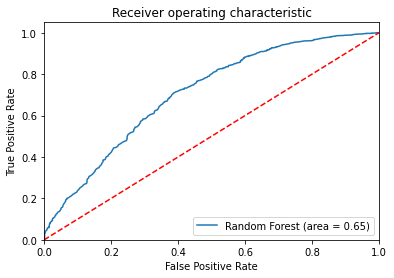

In [69]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.rc("font", size=10)
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()